In [47]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL_ORIG = 'grid search'
ALGORITHM_DETAIL = 'grid search'
VERSION = '02'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [48]:
if False:
    # Use scikit-learn to grid search the batch size and epochs
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import GridSearchCV
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from scikeras.wrappers import KerasClassifier, KerasRegressor


    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(12, input_shape=(8,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


    # fix random seed for reproducibility
    seed = 7
    tf.random.set_seed(seed)
    # load dataset
    dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
    # split into input (X) and output (Y) variables
    X = dataset[:, 0:8]
    Y = dataset[:, 8]
    # create model
    model = KerasRegressor(model=create_model, verbose=0)
    # define the grid search parameters
    batch_size = [10, 20]  #, 40, 60, 80, 100]
    epochs = [10]  #, 50, 100]
    batch_size = [10, 20]
    epochs = [10, 20]
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X, Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [49]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf

from tensorflow import keras
from keras import layers

import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)


def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        #layers.Dense(132, activation='relu'),
        #layers.Dense(132, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


def create_model():
    # create model
    model = Sequential()
    # model.add(Dense(12, input_shape=(8,), activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
    return model


normalizer = tf.keras.layers.Normalization(axis=-1)

dnn_model = build_and_compile_model(normalizer)

model = KerasRegressor(model=create_model, verbose=1)

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    #('model', dnn_model)
    ('model', model)
])
model

2.10.0


KerasRegressor(
	model=<function create_model at 0x7f8c98ba1af0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

In [50]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    import functions_20221012
    from functions_20221012 import set_csv_directory

    set_csv_directory('final_split')

debug_mode = False

In [51]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation']
categories = ['tenure.tenureType']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'tenure.tenureType']
label ->  Price


In [52]:
filename = f'df_listings_v{VERSION}.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):
    retrieval_type = None

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', remote_pathname)
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
            retrieval_type = 'tidy'
            print('loaded data from', df_pathname_tidy)
        except:
            print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
            inDF = functions_20221012.get_combined_dataset(HOW='inner', early_duplicates=True,
                                                           folder_prefix=folder_prefix)
            inDF.to_csv(df_pathname_raw)
            retrieval_type = 'raw'

    if rows and rows > 0:
        #inDF = inDF[:rows]
        inDF = inDF.sample(rows)
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index

#X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(get_source_dataframe(), return_index=True, drop_nulls=False)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,

In [53]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../')
#df, retrieval_type = get_source_dataframe(folder_prefix='../../', rows=5000)
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = functions_20221012.add_supplements(df)
    df.to_csv(df_pathname_raw)
    df = functions_20221012.tidy_dataset(df, version=int(VERSION))

    df = df[columns]

    df.to_csv(df_pathname_tidy)

print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

loaded data from ../../data/final/df_listings_v02.csv
(52117, 7)
Int64Index([ 14520525,  27953107,  33593487,  35271294,  35429088,  44749111,
             46204665,  49020666,  49036279,  49303873,
            ...
            126173423, 126173600, 126175973, 126178769, 126179018, 126179672,
            126180107, 126180704, 126180962, 126181118],
           dtype='int64', length=52117)


In [54]:
df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
14520525,550000.0,51.52995,-0.207020,3.0,1.0,0.274316,LEASEHOLD
27953107,400000.0,51.54939,-0.482600,2.0,2.0,0.305845,LEASEHOLD
33593487,579950.0,51.44718,-0.338770,2.0,1.0,0.438045,FREEHOLD
35271294,370000.0,51.449568,-0.140154,2.0,1.0,0.399307,LEASEHOLD
35429088,599950.0,51.57703,-0.141230,2.0,1.0,0.238187,NaN
...,...,...,...,...,...,...,...
126179672,600000.0,51.35717,-0.074740,3.0,2.0,0.545665,LEASEHOLD
126180107,419999.0,51.531415,-0.052964,2.0,1.0,0.191407,LEASEHOLD
126180704,475000.0,51.543141,0.011498,2.0,1.0,0.308609,LEASEHOLD
126180962,450000.0,51.592105,-0.008233,NaN,1.0,0.476935,FREEHOLD


In [55]:
df.isnull().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms              1742
bathrooms             3173
nearestStation           0
tenure.tenureType     3402
dtype: int64

In [56]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52117 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               52117 non-null  float64
 1   location.latitude   52117 non-null  object 
 2   location.longitude  52117 non-null  float64
 3   bedrooms            50375 non-null  float64
 4   bathrooms           48944 non-null  float64
 5   nearestStation      52117 non-null  float64
 6   tenure.tenureType   48715 non-null  object 
dtypes: float64(5), object(2)
memory usage: 5.2+ MB


,Price,location.longitude,bedrooms,bathrooms,nearestStation
count,52117.000000,52117.000000,50375.000000,48944.000000,52117.000000
mean,419854.956790,-0.104810,11.721787,1.177182,0.445245
std,110342.806124,0.731478,2183.166275,0.410552,1.066809
min,100000.000000,-0.498315,1.000000,1.000000,0.000000
25%,330000.000000,-0.211852,1.000000,1.000000,0.224233
50%,425000.000000,-0.104440,2.000000,1.000000,0.363994
75%,500000.000000,-0.011509,3.000000,1.000000,0.557263
max,600000.000000,51.558746,490000.000000,12.000000,192.431869


In [57]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 52117 ==> 47444


,count,mean,std,min,25%,50%,75%,max
Price,47444.0,424032.547382,108060.063745,100000.000000,345000.000000,425000.000000,511500.000000,600000.000000
location.latitude,47444.0,51.496962,0.077034,51.298317,51.438814,51.499890,51.555916,51.683185
location.longitude,47444.0,-0.113297,0.156316,-0.498315,-0.210785,-0.102333,-0.010485,0.279726
bedrooms,47444.0,1.990557,0.828428,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,47444.0,1.182173,0.410188,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,47444.0,0.439824,0.354467,0.000000,0.226450,0.367506,0.558826,16.168861


In [58]:
df.isna().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms                 0
bathrooms                0
nearestStation           0
tenure.tenureType     2780
dtype: int64

In [59]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

47444 ==> 44664


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation
count,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000
mean,424197.633598,51.496602,-0.113125,1.989208,1.181332,0.439504
std,107989.580699,0.077221,0.155684,0.827142,0.409031,0.353470
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000
25%,345000.000000,51.438246,-0.210584,1.000000,1.000000,0.226771
50%,425000.000000,51.498681,-0.101934,2.000000,1.000000,0.367875
75%,515000.000000,51.555979,-0.010933,3.000000,1.000000,0.558693
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861


In [60]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(40197, 9) (4467, 9) (40197, 1) (4467, 1) (40197, 1) (4467, 1) (40197, 1) (4467, 1)


In [61]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [62]:
from time import time

#pipe.fit(X_train, y_train)

if False:
    model = dnn_model
#model.fit(X_train, y_train)
if False:
    model.get_params()

In [63]:
X_train

array([[ 5.1340698e+01, -4.8786000e-02,  3.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.1529844e+01,  1.6331300e-01,  3.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.1574381e+01,  1.9703700e-01,  2.0000000e+00, ...,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       ...,
       [ 5.1499190e+01,  3.0510000e-02,  1.0000000e+00, ...,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [ 5.1621879e+01, -1.1025400e-01,  2.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 5.1456300e+01, -6.3700000e-03,  1.0000000e+00, ...,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00]])

In [64]:
if True:

    # Use scikit-learn to grid search the batch size and epochs
    import numpy as np
    import tensorflow as tf
    from sklearn.model_selection import GridSearchCV
    from keras.models import Sequential
    from keras.layers import Dense
    from scikeras.wrappers import KerasClassifier


    # Function to create model, required for KerasClassifier
    def create_model():
        global ALGORITHM_DETAIL, ALGORITHM_DETAIL_ORIG

        # create model
        if False:
            model = Sequential()
            #model.add(Dense(12, input_shape=(8,), activation='relu'))
            #model.add(Dense(12, input_shape=(9,), activation='relu'))
            model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            # Compile model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model

        elif False:
            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL += ' [input_dense12, normaliser, dense1]'

            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = Sequential()
            model.add(Dense(12, input_shape=(len(X_train[0]),), activation='relu'))
            #model.add(normalizer)
            model.add(Dense(1, activation='sigmoid'))

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model

        elif True:
            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL += ' [input64, norm, dense64^6, dense1]'

            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = Sequential()
            model.add(Dense(64, input_shape=(len(X_train[0]),), activation='relu'))
            model.add(normalizer)
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1))

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model

        else:
            normalizer = tf.keras.layers.Normalization(axis=-1)
            model = keras.Sequential([
                normalizer,
                layers.Dense(64, activation='relu'),
                layers.Dense(64, activation='relu'),
                #layers.Dense(132, activation='relu'),
                #layers.Dense(132, activation='relu'),
                layers.Dense(1)
            ])

            ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG
            ALGORITHM_DETAIL+= ' [normaliser, dense64, dense64]'

            model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
            return model


# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
# load dataset
dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:, 0:8]
Y = dataset[:, 8]
# create model
model = KerasRegressor(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 100]  #, 40, 60, 80, 100]
epochs = [100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid = RandomizedSearchCV(model, param_grid, n_jobs=-1, cv=2, verbose=5)
#grid_result = grid.fit(X, Y)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2022-10-13 23:04:42.173695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 23:04:42.176572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 23:04:42.177099: I tensorflow/core/plat

[CV 1/2] END ........batch_size=100, epochs=100;, score=0.306 total time= 1.9min
[CV 2/2] END ........batch_size=100, epochs=100;, score=0.297 total time= 2.4min
[CV 1/2] END .........batch_size=10, epochs=100;, score=0.420 total time=11.8min
[CV 2/2] END .........batch_size=10, epochs=100;, score=0.395 total time=12.4min
Best: 0.407185 using {'epochs': 100, 'batch_size': 10}
0.407185 (0.012640) with: {'epochs': 100, 'batch_size': 10}
0.301403 (0.004606) with: {'epochs': 100, 'batch_size': 100}


In [78]:
pipe = grid_result.best_estimator_
timings = []

if False:
    t0 = time()
    pipe.fit(X_train, y_train)
    timings.append(time() - t0)

    print(timings)
else:
    timings = [999]

average_time = sum(timings) / len(timings)
print(average_time)


999.0


In [79]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'epochs': 100, 'batch_size': 10}
0.407 (+/-0.025) for {'epochs': 100, 'batch_size': 10}
0.301 (+/-0.009) for {'epochs': 100, 'batch_size': 100}
Best Index:  0
Best Score:  0.4071848635559558
Best Params:  {'epochs': 100, 'batch_size': 10}


In [80]:
pipe

KerasRegressor(
	model=<function create_model at 0x7f8c55148ee0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [81]:
y_pred = pipe.predict(X_test)
#y_pred = pipe.evaluate(X_test, y_test, verbose=0)
y_pred

array([[314295.25],
       [549913.5 ],
       [467879.2 ],
       ...,
       [380458.38],
       [461888.7 ],
       [451476.7 ]], dtype=float32)

In [82]:
pipe

KerasRegressor(
	model=<function create_model at 0x7f8c55148ee0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [83]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy 0.3839947608977107
Mean Absolute Error Accuracy 65173.142769196325
Mean Squared Error Accuracy 7048819025.755178
Root Mean Squared Error 83957.24522490705


In [84]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [85]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
124597034.0,285000.0,314295.250000,29295.250000,10.279035,9.320933
82883871.0,500000.0,549913.500000,49913.500000,9.982700,9.076609
123298382.0,435000.0,467879.187500,32879.187500,7.558434,7.027281
119192408.0,300000.0,252494.265625,47505.734375,15.835245,18.814580
116845355.0,600000.0,485004.125000,114995.875000,19.165979,23.710288
...,...,...,...,...,...
123467048.0,449950.0,444606.875000,5343.125000,1.187493,1.201764
114663482.0,375000.0,321653.812500,53346.187500,14.225650,16.584970
123013478.0,500000.0,380458.375000,119541.625000,23.908325,31.420421


In [86]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType


In [87]:
score = pipe.score(X_test, y_test)
score

0.3839947608977107

In [88]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.3839947608977107

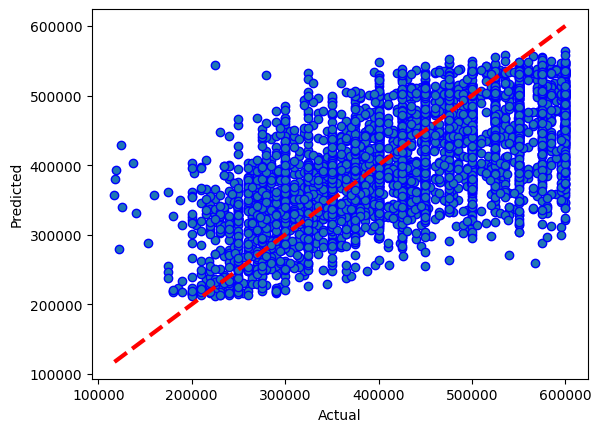

In [89]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [90]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
}
import json


def get_results():
    results_filename = '../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = results_json[key]['date']
        first_run_date = results_json[key]['first run']
    except:
        pass

    results['first run'] = first_run_date

    results_json[key] = new_results

    results_filename = '../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(results_json, indent=4))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'Score': 0.3839947608977107,
 'R square Accuracy': 0.3839947608977107,
 'Mean Absolute Error Accuracy': 65173.142769196325,
 'Mean Squared Error Accuracy': 7048819025.755178,
 'Root Mean Squared Error': 83957.24522490705,
 'Training Time': 999.0,
 'random_state': 101,
 'date': '2022-10-13 23:34:58.109251',
 'first run': '2022-10-13 23:34:58.113261'}